## 4.3 앙상블 학습 개요

### Voting Classifier

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


c:\users\ad\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\ad\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

## 4.4 Random Forest

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [7]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


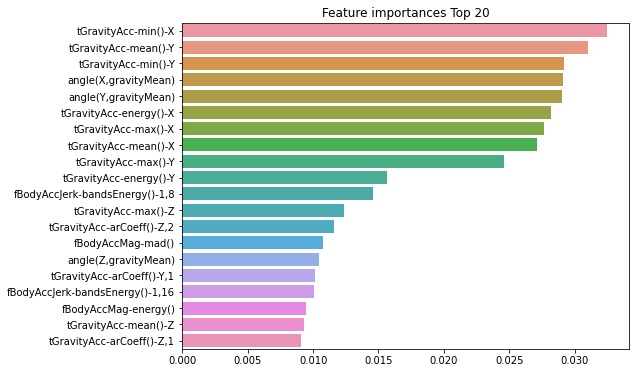

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## 4.5 GBM(Gradient Boosting Machine)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 600.2 초 


In [10]:
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 600.2 초 


In [11]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: 0.9011


In [12]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9420


## 4.6 SVM

In [13]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5)

In [14]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
#print(y_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.9733333333333334


## 4.7 kNN

In [15]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.feature_names)
print(iris.target_names)
print(iris.data[0])
print(iris.target[0])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[5.1 3.5 1.4 0.2]
0


In [16]:
for i in range(len(iris.target)):
    print("Example %d: label %s, features %s" % (i, iris.target[i], iris.data[i]))

Example 0: label 0, features [5.1 3.5 1.4 0.2]
Example 1: label 0, features [4.9 3.  1.4 0.2]
Example 2: label 0, features [4.7 3.2 1.3 0.2]
Example 3: label 0, features [4.6 3.1 1.5 0.2]
Example 4: label 0, features [5.  3.6 1.4 0.2]
Example 5: label 0, features [5.4 3.9 1.7 0.4]
Example 6: label 0, features [4.6 3.4 1.4 0.3]
Example 7: label 0, features [5.  3.4 1.5 0.2]
Example 8: label 0, features [4.4 2.9 1.4 0.2]
Example 9: label 0, features [4.9 3.1 1.5 0.1]
Example 10: label 0, features [5.4 3.7 1.5 0.2]
Example 11: label 0, features [4.8 3.4 1.6 0.2]
Example 12: label 0, features [4.8 3.  1.4 0.1]
Example 13: label 0, features [4.3 3.  1.1 0.1]
Example 14: label 0, features [5.8 4.  1.2 0.2]
Example 15: label 0, features [5.7 4.4 1.5 0.4]
Example 16: label 0, features [5.4 3.9 1.3 0.4]
Example 17: label 0, features [5.1 3.5 1.4 0.3]
Example 18: label 0, features [5.7 3.8 1.7 0.3]
Example 19: label 0, features [5.1 3.8 1.5 0.3]
Example 20: label 0, features [5.4 3.4 1.7 0.2]
Ex

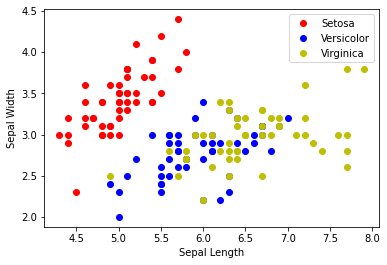

In [17]:
import matplotlib.pyplot as plt
sepal = iris.data[:, 0:2]
kind = iris.target
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.plot(sepal[kind==0][:,0], sepal[kind==0][:,1],"ro", label='Setosa')
plt.plot(sepal[kind==1][:,0], sepal[kind==1][:,1],"bo", label='Versicolor')
plt.plot(sepal[kind==2][:,0], sepal[kind==2][:,1],"yo", label='Virginica')
plt.legend()

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
#print(iris.data)
from sklearn.model_selection import train_test_split
X = iris.data
y = iris.target
# (80:20)으로 분할한다. 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print(X_train.shape)
print(X_test.shape)

(120, 4)
(30, 4)


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=6) #주변 6개 탐색
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
scores = metrics.accuracy_score(y_test, y_pred)
scores

0.9666666666666667

In [20]:
knn = KNeighborsClassifier(n_neighbors=5) #주변 5개 탐색
knn.fit(X, y)
#0 = setosa, 1=versicolor, 2=virginica
classes = {0:'setosa',1:'versicolor',2:'virginica'}
# 아직 보지 못한 새로운 데이터를 제시해보자. 
x_new = [[3,4,5,2],
[5,4,2,2]]
y_predict = knn.predict(x_new)
print(classes[y_predict[0]])
print(classes[y_predict[1]])

versicolor
setosa
